In [1]:
import dask.array as da
import dask
from dask.distributed import Client, performance_report

In [2]:
x = da.zeros((12500, 10000), chunks=('10MB', -1))
x

dask.array<zeros_like, shape=(12500, 10000), dtype=float64, chunksize=(125, 10000), chunktype=numpy.ndarray>

In [3]:
da.to_zarr(x, "__pycache__/data/saved_x1.zarr", overwrite=True)
da.to_zarr(x, "__pycache__/data/saved_y1.zarr", overwrite=True)

da.to_zarr(x, "__pycache__/data/saved_x2.zarr", overwrite=True)
da.to_zarr(x, "__pycache__/data/saved_y2.zarr", overwrite=True)

In [4]:
x1 = da.from_zarr('__pycache__/data/saved_x1.zarr')
y1 = da.from_zarr('__pycache__/data/saved_x2.zarr')
x2 = da.from_zarr('__pycache__/data/saved_y1.zarr')
y2 = da.from_zarr('__pycache__/data/saved_y2.zarr')

In [5]:
def evaluate(x1, y1, x2, y2):
    u = da.stack([x1, y1])
    v = da.stack([x2, y2])
    
    components = [u, v, u ** 2 + v ** 2]
    return [
        abs(c[0] - c[1]).mean(axis=-1)
        for c in components
    ]

n = 125 * 4
results = evaluate(x1[:n], y1[:n], x2[:n], y2[:n])
results

[dask.array<mean_agg-aggregate, shape=(500,), dtype=float64, chunksize=(125,), chunktype=numpy.ndarray>,
 dask.array<mean_agg-aggregate, shape=(500,), dtype=float64, chunksize=(125,), chunktype=numpy.ndarray>,
 dask.array<mean_agg-aggregate, shape=(500,), dtype=float64, chunksize=(125,), chunktype=numpy.ndarray>]

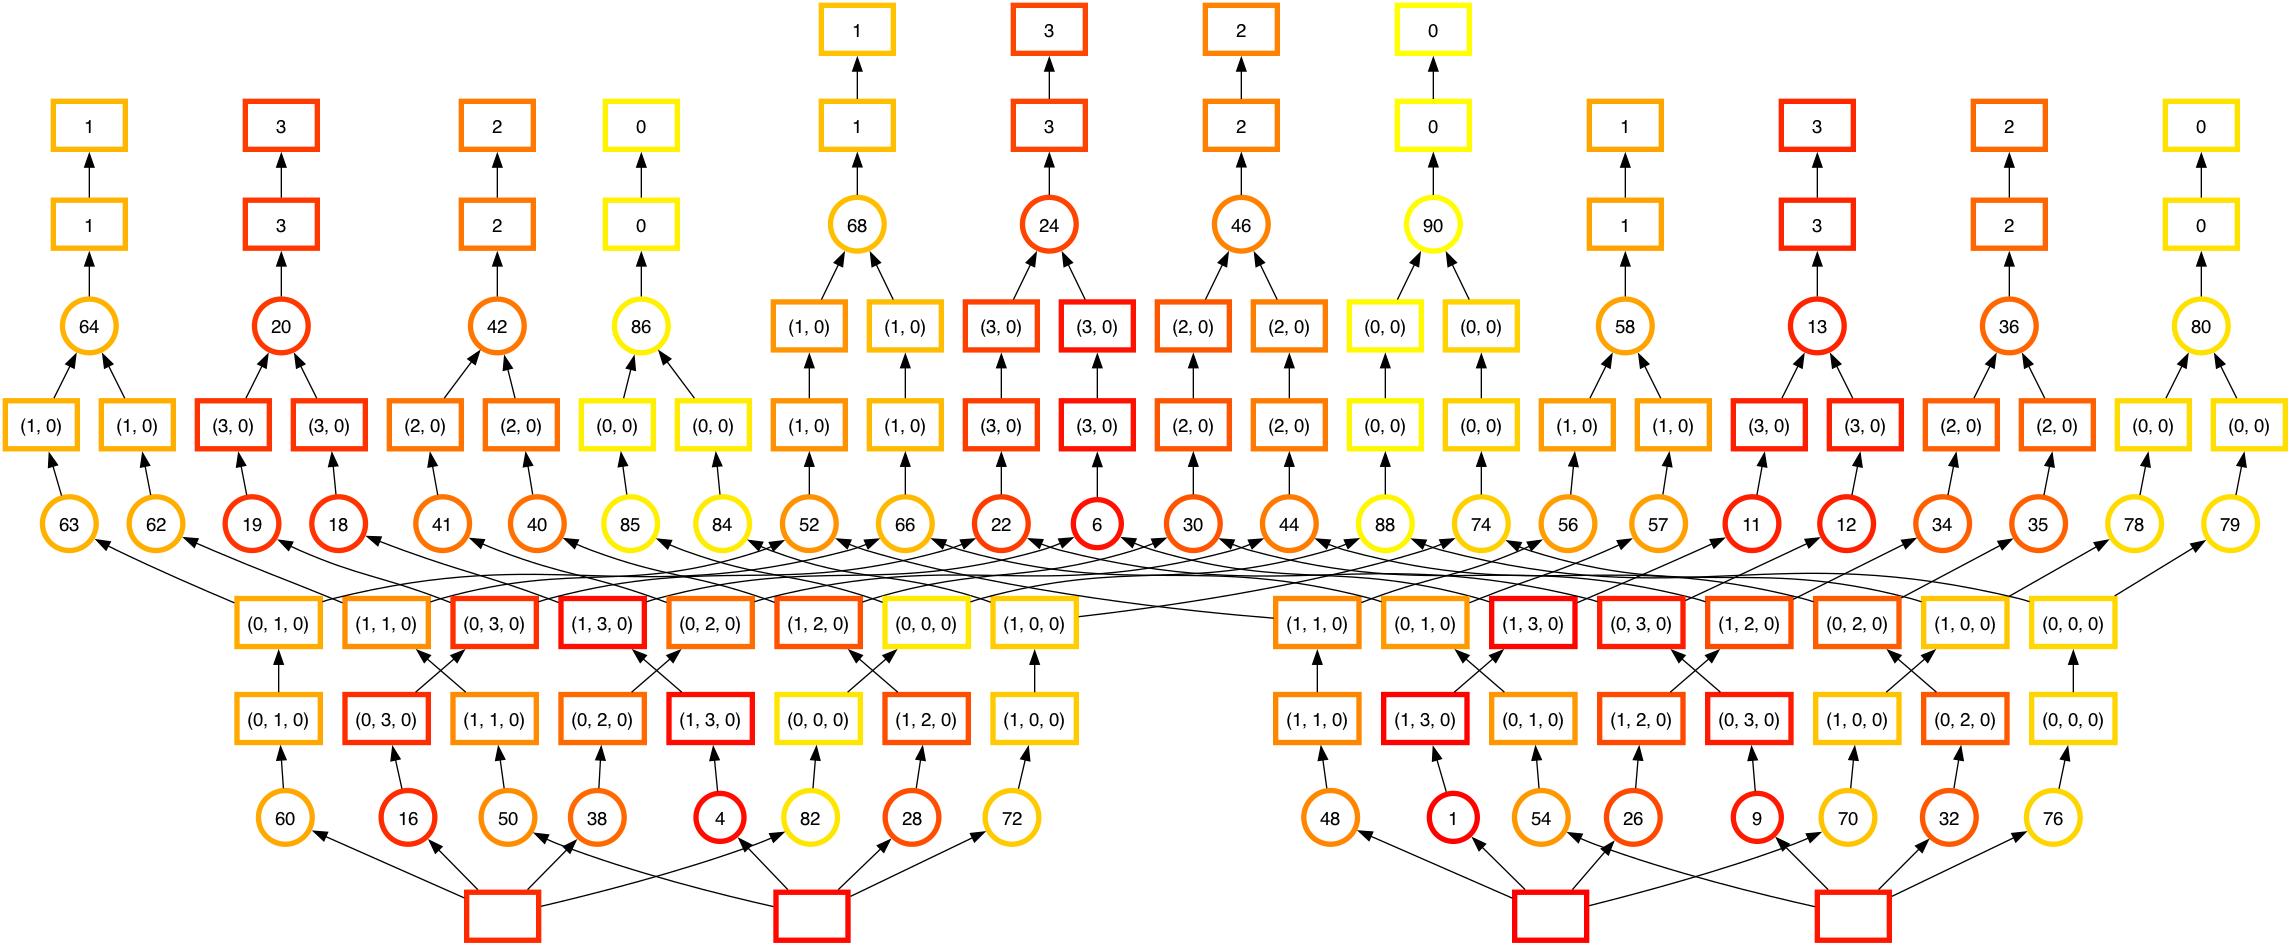

In [7]:
dask.visualize(results,  optimize_graph=True, cmap="autumn", node_attr={"penwidth": "4"}, color='order')

In [10]:
results[0].dask

HighLevelGraph with 13 layers.
<dask.highlevelgraph.HighLevelGraph object at 0x15a490670>
 0. original-from-zarr-29046f8580ea540ea8b9402c9d9795c3
 1. from-zarr-29046f8580ea540ea8b9402c9d9795c3
 2. getitem-ed33f4257cc98c9d86ea274bb23f39ec
 3. original-from-zarr-b86d06dc7c4736ceef56e0c0d0e5af4d
 4. from-zarr-b86d06dc7c4736ceef56e0c0d0e5af4d
 5. getitem-c8d738cbe21502c64bf9bd3a65eca0b5
 6. stack-576b40ac713fcb33a7513cd148008c3f
 7. getitem-8a064bd748e2a143aa787cb3553dfdf9
 8. getitem-e930bbed5998d3dd2d58a6aa337e457b
 9. sub-355c38cde8a95825d373f7b0914bd4c9
 10. abs-d8a1a780e1ba46de42c427217504d0d2
 11. mean_chunk-53c7b82e972b136fba07af296fb1d71a
 12. mean_agg-aggregate-85b94be6a1c9bedbdda1c02171b37ba6

In [17]:
client = Client("tcp://172.20.104.205:8786")
client

<Client: 'tcp://172.20.104.205:8786' processes=2 threads=8, memory=8.00 GiB>

In [26]:
with performance_report(filename="dask-report.html"):
    dask.compute(*results)

In [31]:
dask.visualize(results[0])